# Generate knowledge with Semantic Graphs and RAG

[txtai](https://github.com/neuml/txtai) is an all-in-one embeddings database for semantic search, LLM orchestration and language model workflows.

Embeddings databases are a union of vector indexes (sparse and dense), graph networks and relational databases. This enables vector search with SQL, topic modeling, retrieval augmented generation and more.

Semantic graphs were introduced in late 2022 with txtai 5.0, right before the start of the LLM era. This notebook picks back up where that work left off, opening a new frontier in semantic graph integration.

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[graph] autoawq

# Create a Semantic Graph

First, we're going to create a semantic graph using data from `txtai-wikipedia`, a full Wikipedia txtai embeddings database. We'll use the top 100K articles sorted by popularity.

In [ ]:
from txtai import Embeddings

# Create embeddings instance with a semantic graph
embeddings = Embeddings({
  "autoid": "uuid5",
  "path": "intfloat/e5-base",
  "instructions": {
    "query": "query: ",
    "data": "passage: "
  },
  "content": True,
  "graph": {
      "approximate": False,
      "topics": {}
  }
})

# Load dataset
wikipedia = Embeddings()
wikipedia.load(provider="huggingface-hub", container="neuml/txtai-wikipedia")

query = """
SELECT id, text FROM txtai
order by percentile desc
LIMIT 100000
"""

embeddings.index(wikipedia.search(query))

The code above creates a new embeddings database with a graph component. This adds a separate graph index alongside the database and vector index components.

A semantic graph automatically creates edges between graph nodes using the vector model associated with the embeddings database. Relationships can also be manually specified.

Next, we'll run a search and return a filtered graph containing only the results of a search. This is a new feature as of txtai 7.0.

In [ ]:
graph = embeddings.search("Large Language Models", 50, graph=True)

Let's repeat that again, this ran a search and created it's own graph of the search results. 🔥🔥🔥 This opens up a lot of interesting possibilities!

Time to plot the search results.

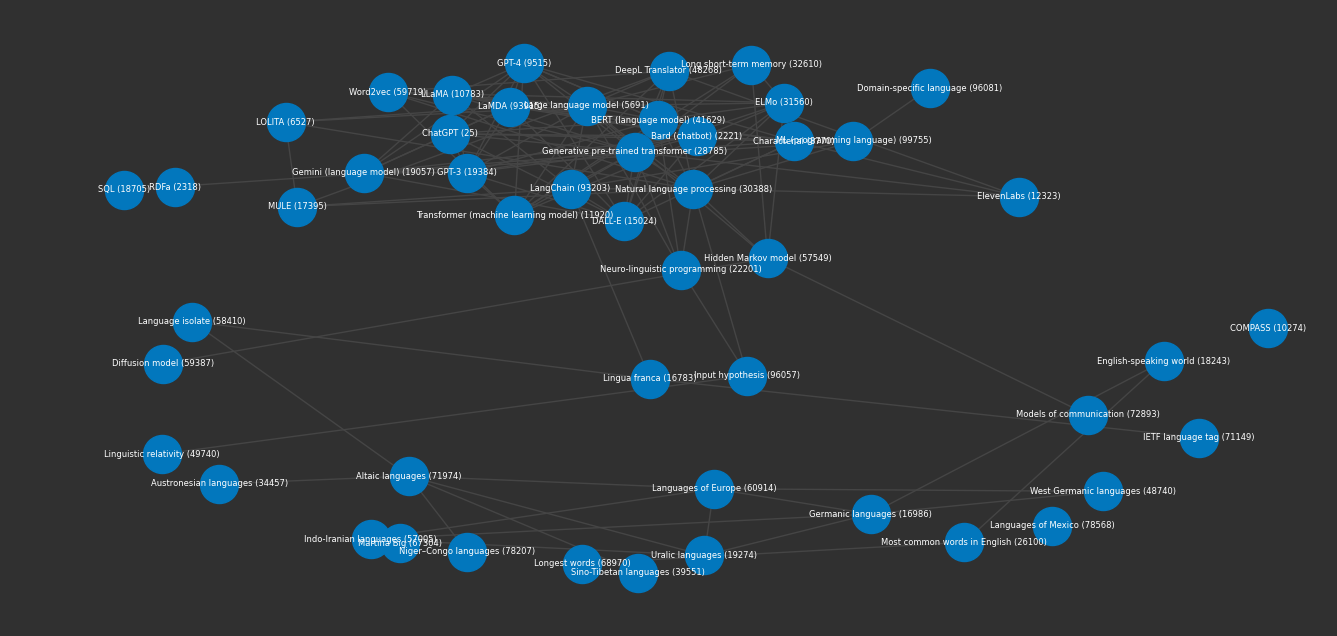

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'id')} ({x})" for x in graph.scan()}
    options = {
        "node_size": 750,
        "node_color": "#0277bd",
        "edge_color": "#454545",
        "font_color": "#fff",
        "font_size": 6,
        "alpha": 1.0
    }

    fig, ax = plt.subplots(figsize=(17, 8))
    pos = nx.spring_layout(graph.backend, seed=0, k=0.9, iterations=50)
    nx.draw_networkx(graph.backend, pos=pos, labels=labels, **options)
    ax.set_facecolor("#303030")
    ax.axis("off")
    fig.set_facecolor("#303030")

    plt.show()

plot(graph)

This graph shows all the interconnections between the search results. The numbers on each node are the internal node id (same as the index id in an embeddings index).

Let's explore the path between two of these nodes.

In [ ]:
for x in graph.showpath(49740, 96081):
    print(graph.node(x))

{'id': 'Linguistic relativity', 'text': "The idea of linguistic relativity, also known as the Sapir–Whorf hypothesis, the Whorf hypothesis, or Whorfianism, is a principle suggesting that the structure of a language influences its speakers' worldview or cognition, and thus individuals' languages determine or shape their perceptions of the world. ", 'topic': 'language_word_languages_also', 'topicrank': 6, 'score': 0.794975996017456}
{'id': 'Input hypothesis', 'text': 'The input hypothesis, also known as the monitor model, is a group of five hypotheses of second-language acquisition developed by the linguist Stephen Krashen in the 1970s and 1980s. Krashen originally formulated the input hypothesis as just one of the five hypotheses, but over time the term has come to refer to the five hypotheses as a group. The hypotheses are the input hypothesis, the acquisition–learning hypothesis, the monitor hypothesis, the natural order hypothesis and the affective filter hypothesis. The input hypoth

The logic above walked the graph starting at the node for `Linguistic relativity (49740)` and ending at `Domain-specific language (96081)`.

The nodes in between are semantically related and were used to find a semantic path between the nodes.

# RAG with Semantic Graphs

Retrieval augmented generation (RAG) helps reduce the risk of hallucinations by limiting the context in which a LLM can generate answers. This is typically done with a vector search query that hydrates a prompt with a relevant context.

Can we use the semantic graph to power a RAG system? Of course but how?

Looking at the graph above, the most connected nodes are in the middle of the graph. These nodes are the ones that best overall cover the topic in the original query.

Where does this differ from a vector query? Well this method not only looks at semantic similarity between the search and results but the similarity within the results. It's effectively judging the results to see which result is most similar to other results.

Let's show the top 10 central nodes in the graph.

In [ ]:
for x in list(graph.centrality().keys())[:10]:
    print(graph.node(x))

{'id': 'Generative pre-trained transformer', 'text': 'Generative pre-trained transformers (GPT) are a type of large language model (LLM) and a prominent framework for generative artificial intelligence. They are artificial neural networks that are used in natural language processing tasks. GPTs are based on the transformer architecture, pre-trained on large data sets of unlabelled text, and able to generate novel human-like content. As of 2023, most LLMs have these characteristics and are sometimes referred to broadly as GPTs.', 'topic': 'artificial_learning_intelligence_based', 'topicrank': 11, 'score': 0.8267543315887451}
{'id': 'Large language model', 'text': 'A large language model (LLM) is a large-scale language model notable for its ability to achieve general-purpose language understanding and generation. LLMs acquire these abilities by using massive amounts of data to learn billions of parameters during training and consuming large computational resources during their training a

Overall, these all pass the eye test. If we scroll over to see the associated score with the original query we'll note that the highest scores aren't necessarily the most central nodes.

Conceptually this makes sense. We searched for `Large Language Models`, so that page makes sense to score highly. Then we have the GPT page which is even more central. When we think of core concepts with LLMs and the most popular incarnation, ChatGPT, this also makes sense.

Now let's load a LLM and use the central graph nodes as context for RAG.

In [ ]:
from txtai import LLM
llm = LLM("TheBloke/Mistral-7B-OpenOrca-AWQ")

In [ ]:
def facts(graph):
    question = "List 5 facts from this text"
    text = "\n".join(graph.node(x)["text"] for x in list(graph.centrality().keys())[:10])

    prompt = f"""<|im_start|>system
    You are a friendly assistant. You answer questions from users.<|im_end|>
    <|im_start|>user
    Answer the following question using only the context below. Only include information specifically discussed.

    question: {question}
    context: {text} <|im_end|>
    <|im_start|>assistant
    """

    print(llm(prompt, maxlength=4096))

facts(graph)

1. GPTs are a type of large language model (LLM) and a prominent framework for generative artificial intelligence.
2. They are artificial neural networks used in natural language processing tasks and are based on the transformer architecture.
3. GPTs are pre-trained on large data sets of unlabelled text and can generate novel human-like content.
4. As of 2023, most LLMs have these characteristics and are sometimes referred to broadly as GPTs.
5. LLMs acquire their abilities by using massive amounts of data to learn billions of parameters during training and consume large computational resources during their training and operation.


An interesting summary on LLMs. It's no surprise that GPT and LLM are almost interchangable!

# Explore Wikipedia

RAG with Semantic Graphs is great when we don't have a direct question but instead want to explore a topic. We can start with a topic and this method can tell us about the data. Often one of the hardest parts of search is knowing what to look for.

Let's explore some history.

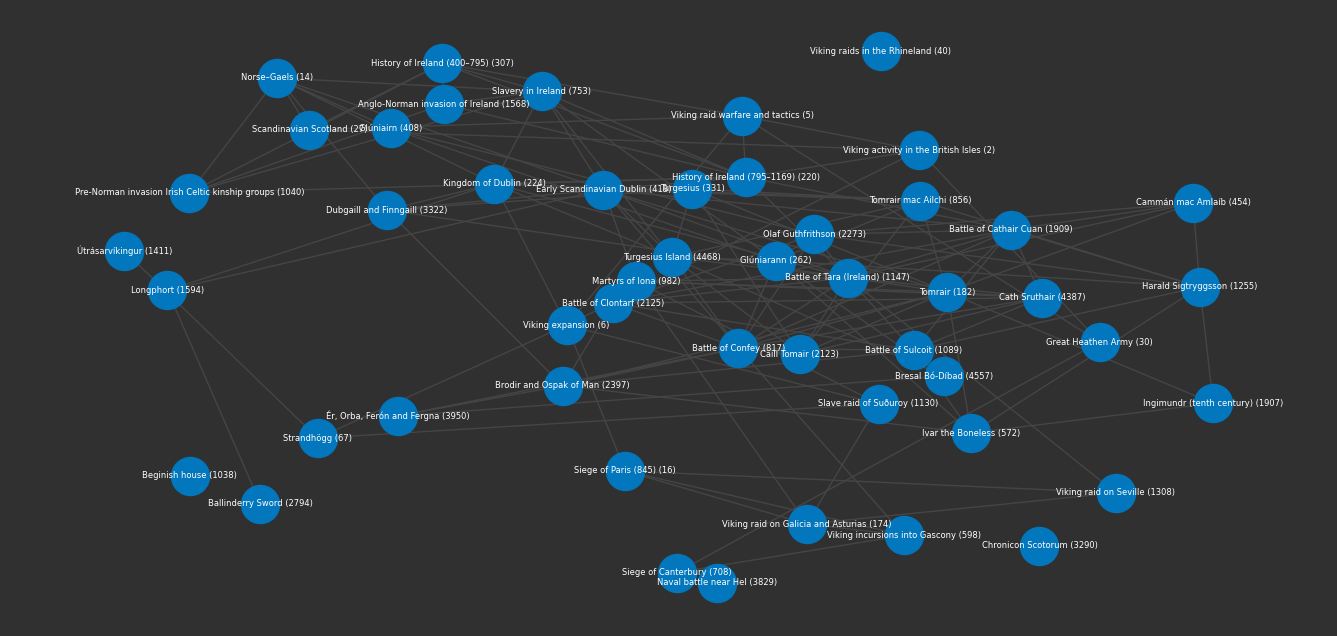

In [ ]:
query = """
SELECT id, text FROM txtai
WHERE similar(:x)
LIMIT 5000
"""

embeddings.index(wikipedia.search(query, parameters={"x": "Vikings in the middle ages"}))

graph = embeddings.search("Viking raids in Ireland", 50, graph=True)
plot(graph)

Let's learn about the Viking Age in Ireland.

In [ ]:
facts(graph)

1. The Battle of Tara was fought between the Gaelic Irish of Meath, led by Máel Sechnaill mac Domnaill, and the Norse Vikings of Dublin, led by Amlaíb Cuarán, in 980 near the Hill of Tara in Ireland.
2. The Vikings had formed temporary alliances with certain Irish clans between 950-980 AD, which allowed them to continue their raids and plunder of the island.
3. The Battle of Tara was a devastating defeat for the Vikings, leading to the Irish regaining control of Dublin.
4. The First Viking Age in Ireland began in 795 with Viking raiders targeting Gaelic Irish coastal settlements.
5. The Norse Kingdom of Dublin, the earliest and longest-lasting Norse kingdom in Ireland, was established by Vikings in the 9th century and became the biggest slave port in Western Europe under their rule.


Interesting, I definitely learned a few things!

Now let's learn about the Roman Empire and it's armies.

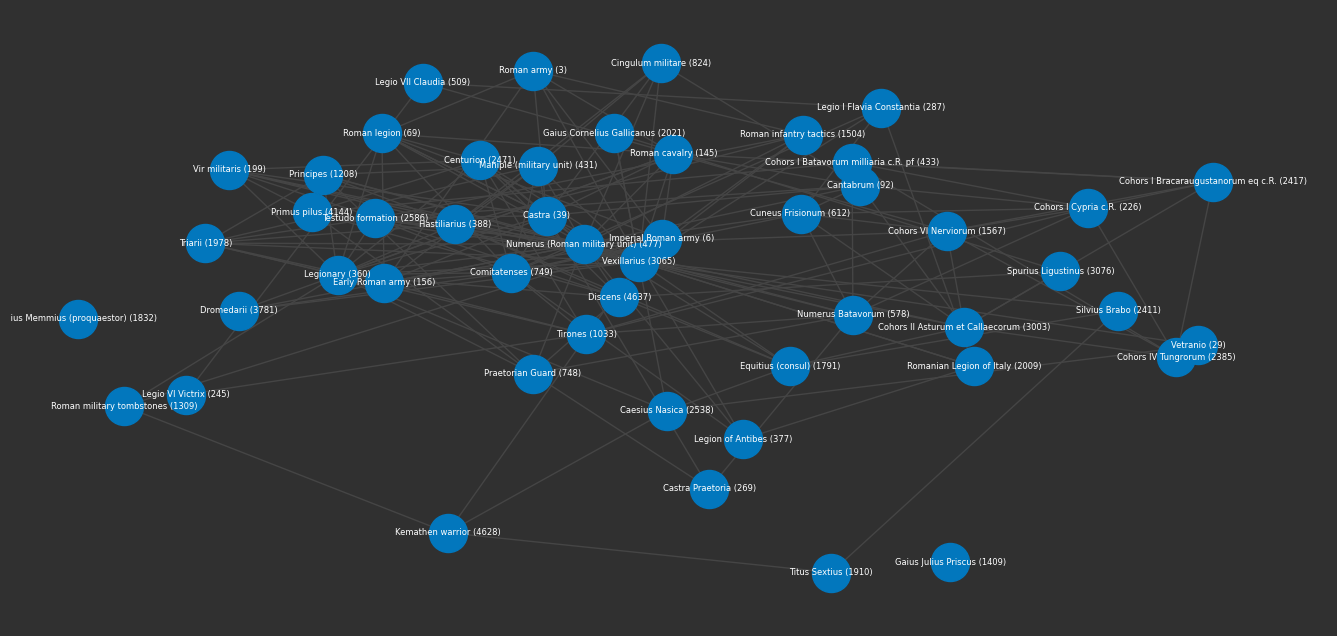

In [ ]:
embeddings.index(wikipedia.search(query, parameters={"x": "Roman Empire"}))

graph = embeddings.search("Roman soldiers", 50, graph=True)
plot(graph)

In [ ]:
facts(graph)

1. Vexillarius is a term referring to a type of Roman soldier.
2. A numerus was a unit of the Roman army.
3. Roman legionaries were professional heavy infantrymen who conquered and defended territories during the late Republic and Principate eras.
4. Comitatenses and later Palatini were units of the field armies of the late Roman Empire, replacing the legionaries.
5. A hastiliarius was a weapons instructor in the Roman Empire who trained troops in standard weapons and fighting techniques.


# Explore ArXiv

There is also a full ArXiv txtai index available on the Hugging Face Hub. This has the full metadata set (titles + abstracts). Let's take a look at this.

In [ ]:
# Load dataset
arxiv = Embeddings()
arxiv.load(provider="huggingface-hub", container="neuml/txtai-arxiv")

query = """
SELECT id, text FROM txtai
WHERE similar(:x)
LIMIT 1000
"""

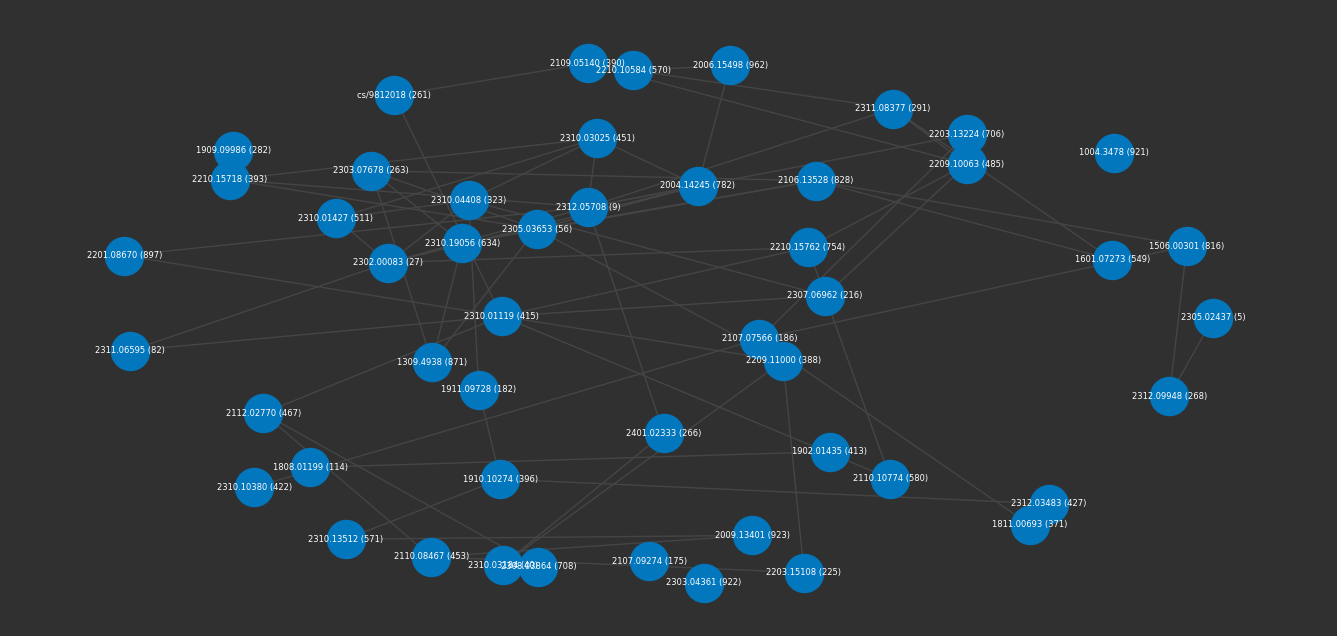

In [ ]:
embeddings.index(arxiv.search(query, parameters={"x": "Retrieval-Augmented Generation"}))

graph = embeddings.search("Best ways to populate context", 50, graph=True)
plot(graph)

In [ ]:
facts(graph)

1. Context Tuning for Retrieval Augmented Generation (RAG) improves tool retrieval and plan generation by employing a smart context retrieval system to fetch relevant information.
2. Synthetic Data Generation in Low-Resource Settings via Fine-Tuning of Large Language Models aims to improve downstream performance of smaller models by generating synthetic data.
3. Query Expansion by Prompting Large Language Models leverages the generative abilities of LLMs for query expansion using prompts like zero-shot, few-shot, and Chain-of-Thought (CoT).
4. In-Context Retrieval-Augmented Language Models prepend grounding documents to the input without modifying the LM architecture, providing significant LM gains across model sizes and diverse corpora.
5. Generate rather than Retrieve: Large Language Models are Strong Context Generators proposes a generate-then-read (GenRead) method that prompts a large language model to generate context-based documents for answering questions.


This wouldn't be an article about RAG without exploring the literature available on RAG! Definitely some interesting articles here.

Last we'll run my "go-to" ArXiv demo query on the search for ET 👽.

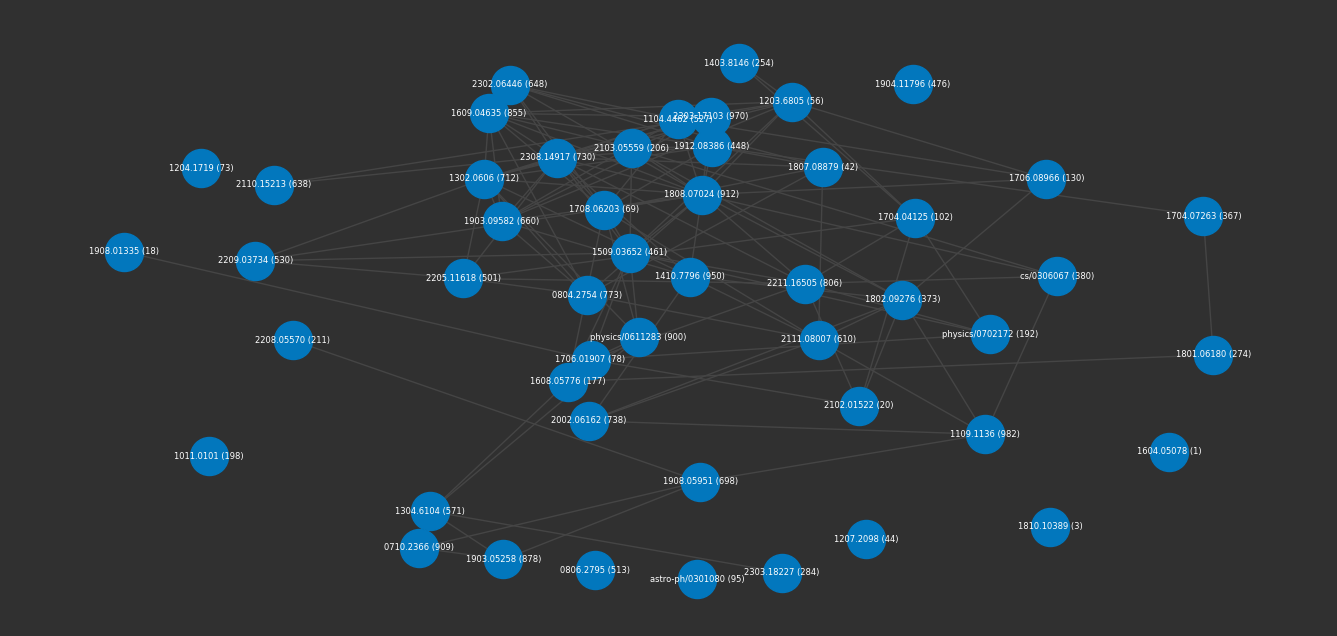

In [ ]:
embeddings.index(arxiv.search(query, parameters={"x": "Alien life"}))

graph = embeddings.search("Alien encounters on Earth", 50, graph=True)
plot(graph)

In [ ]:
facts(graph)

1. Earth has been thoroughly surveilled.
2. Earth will be contacted in due course.
3. SETI beyond half the distance that Earth's EM has reached (~35-50 LY) is futile.
4. The very quiescence of the galaxy paradoxically implies that that Drake's N = many, and that there is a system of galactic governance.
5. Search strategies are proposed to detect the described probe-node-land base communications pathway.


The literature in ArXiv is pretty direct on what's going to happen! 👽

# Topic Generation

The last item we'll cover in this article is topic generation. Semantic graphs have a built-in method to create topic labels using a BM25 index. This works well enough to give a general idea on what the documents in an article discuss.

Can we do better with a LLM?

In [ ]:
def topic(graph):
    topic = list(graph.topics.keys())[0]

    text = "\n".join(graph.node(x)["text"] for x in graph.topics[topic])

    prompt = f"""<|im_start|>system
    You are a friendly assistant. You answer questions from users.<|im_end|>
    <|im_start|>user
    Label the following text with a topic name in a couple words.

    text: {text}
    topic: <|im_end|>
    <|im_start|>assistant
    """

    print(f"Topic: \"{topic}\", Generated Topic: \"{llm(prompt, maxlength=4096)}\"")

topic(graph)

Topic: "from_reported_reports_earth", Generated Topic: "UFOs and Alien Encounters"


The code above took the article text for a topic and run it through a LLM prompt. Looking at the original topic, we have some idea on what it has to do with but the LLM is much more direct.

The BM25 index is fast. The LLM is not. It's a tradeoff but an option to consider.

# Wrapping up

This notebook (re)introduced the semantic graph and ways that it can be used standalone as well as with LLMs/RAG.

Semantic graphs, as constructed in txtai, are a novel approach that few if any other systems have. So expect some disruption once this becomes more popular and known!